# **Transfer Learning and Fine Tuning using Resnet18 Architecture**
In last tutorial,you saw  how to classify images into different categories by using transfer learning from a pre-trained network in VGG19. We have already discussed various pre-trained models and their architectures in the "Common Pre-Trained Models" section. To recap, a pre-trained model is a saved network that has already been trained on a vast dataset.

In this notebook, We will learn how to fine tune a Resnet architecture on a custom dataset. In this notebook we will use the 18 layer architecture of resnet.

# **Set-up Environment**
First, we import the libraries that we'll use: [torchvision](https://pytorch.org/vision/stable/index.html) and other helpful libraries. The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

In [ ]:
import os
import time
import copy
import numpy as np
import collections

# Plotting imports
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Torch imports
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Torchvision imports
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2

# Enable CuDNN benchmark mode for improved performance on compatible GPUs
cudnn.benchmark = True

# Turn on interactive mode for matplotlib
plt.ion()

# selecting the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Data Preprocessing**

## Data Download
In this tutorial, we will be working with the well-known CIFAR10 dataset, which features images of 10 different classes. The CIFAR-10 dataset consists of 60,000 32x32 colour images, with 6000 images per class. Our main objective is to train a model that can accurately classify these images. Further details about the dataset will be provided in subsequent sections.

Note: You can download the data from this [link](https://www.cs.toronto.edu/~kriz/cifar.html). The data is available in 🤗 [Face Datasets](https://huggingface.co/datasets/cifar10) as well. We will use the torchvision and torch.utils.data packages to load the data. You can learn more about loading images in this [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

## Data preparation and augmentation
Here, we focus on optimizing our dataset for training and validation purposes. To achieve this, we use PyTorch's transforms module to implement crucial transformations. For the training set, we employ [resized transformation](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#resize) and [Autoaugment transformation](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#autoaugment) techniques to enhance dataset diversity, which in turn promotes better model generalization. Furthermore, we apply **normalization** to pixel values for both training and validation sets, ensuring efficient neural network processing. This comprehensive data preparation step lays a strong foundation for subsequent model training and evaluation.

In [ ]:
batch_size = 128
learning_rate = 1e-4

In [ ]:
# Classes in CIFAR-10 dataset (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
NUM_CLASSES = 10
# Image size for VGG19 (224x224)
IMAGE_SIZE = 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# Data transformations for training set
train_transforms = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
    v2.ToTensor(),
    v2.Normalize(mean, std)
])

# Data transformations for validation set
validation_transforms = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
    v2.Normalize(mean, std)
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# Dataset for training objectives
train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transforms
)

# Dataset for validation objectives
validation_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=validation_transforms
)

100%|██████████| 170498071/170498071 [00:03<00:00, 43987123.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Number of images in each dataset
print('Train dataset size:', len(train_set))
print('Validation dataset size:', len(validation_set))

Train dataset size: 50000
Validation dataset size: 10000


In [ ]:
def plot_class_distribution(dataset, dataset_name):
    """
    Print and plot the class distribution of a dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to analyze.
        dataset_name (str): The name of the dataset.

    Returns:
        None
    """
    # Extract labels from the dataset
    labels = [y for _, y in dataset]

    # Count the number of images per category
    counter = collections.Counter(labels)

    # Print class image counter
    print(f"Class Image Counter for {dataset_name} Data")
    print(counter, "\n")

    # Optionally, plot the class distribution
    plt.bar(counter.keys(), counter.values())
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution for {dataset_name} Data")
    plt.show()

Class Image Counter for Training Data
Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}) 



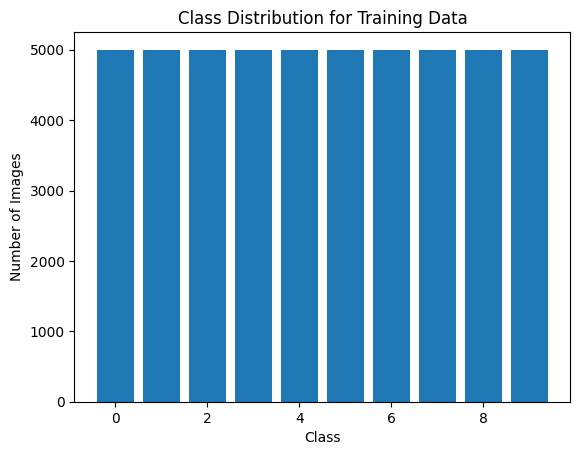

Class Image Counter for Validation Data
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}) 



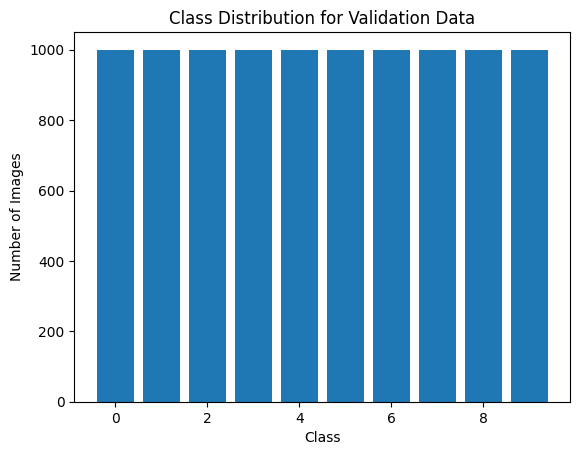

In [ ]:
# # Train dataset and test dataset (all classes) class distribution
plot_class_distribution(train_set, "Training")
plot_class_distribution(validation_set, "Validation")

So, there are 10,000 test samples and 50,000 training samples in the dataset. Additionally, each class in the training dataset has 6,000 images, while each class in the validation dataset has 1,000 images.

In [ ]:
num_gpus = torch.cuda.device_count()

# DataLoader for training set
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2*num_gpus,
    pin_memory=True
)

# DataLoader for validation set
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2*num_gpus,
    pin_memory=True
)

In [ ]:
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


The image batch dimensions are given as torch.Size([128, 3, 224, 224]), indicating a batch size of 128 images, each with 3 color channels (RGB), and each image having dimensions of 224x224 pixels.

The image label dimensions are specified as torch.Size([128]), denoting the corresponding labels for the batch of 128 images. Each label is a single-dimensional tensor.

Note: The initial images in the dataset were of size 32x32. However, to train the Resnet18 model effectively, we need to resize the images to the size it was originally trained on, which is 224x224. Hence, we have applied the resize transformation.

## Visualize a few images
To better understand the data augmentations, let us visualize a few training images.

In [ ]:
def imshow(tensor, title=None):
    """
    Display a batch of images in a grid.

    Args:
        tensor (torch.Tensor): The input tensor containing the images.
        title (str, optional): The title of the plot. Defaults to None.
    """
    image = torchvision.utils.make_grid(tensor).numpy().transpose((1, 2, 0))

    # Denormalize the image
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    # Increase the plot size
    plt.figure(figsize=(20, 10))

    # Plot the image
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

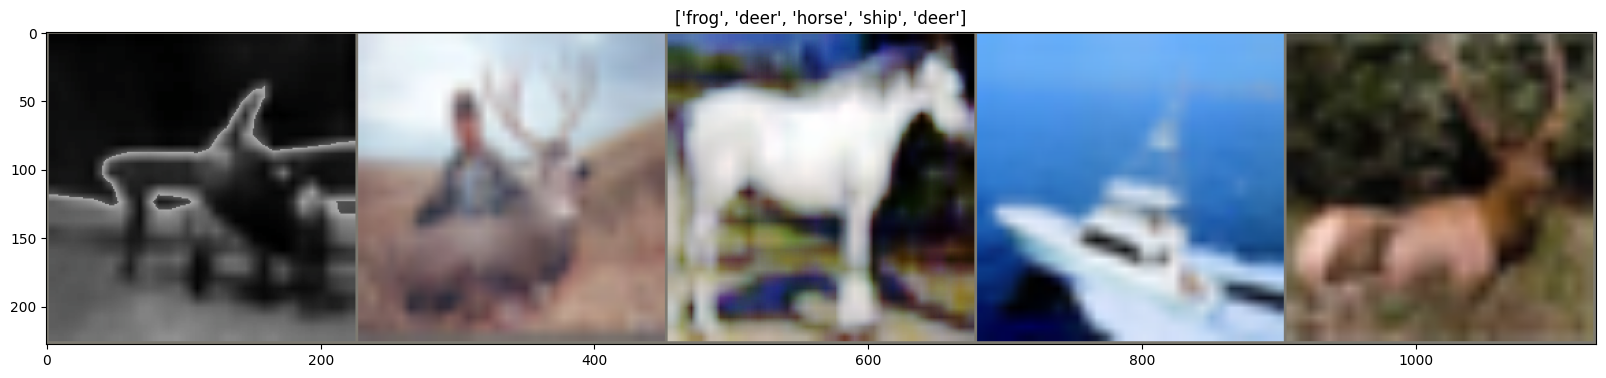

In [ ]:
# Image classes in CIFAR-10 dataset
classes = (
    "frog",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "plane",
    "horse",
    "ship",
    "truck",
)

# Get a batch of training data
for inputs, labels in train_loader:
    # Display the first 8 images from the batch
    imshow(inputs[:5], title=[classes[x] for x in labels[:5]])

    break  # Break the loop after it finishes

# **Model training**
This section presents our model training function, which encompasses learning rate scheduling and model checkpointing. The scheduler parameter improves the learning rate, hence increasing the efficiency of model convergence. Model checkpointing saves the best-performing model, ensuring iteration with the highest validation performance. The training function is enhanced with auxiliary functions such as metrics_batch and loss_epoch, leading to a streamlined training process.

## Helper functions
Some helper functions regarding our model loss and learning rate will help us better deal with model training.

In [ ]:
def get_lr(opt):
    """
    Helper function to get the current learning rate from the optimizer.

    Args:
        opt (Optimizer): The optimizer object.

    Returns:
        float: The current learning rate.
    """
    for param_group in opt.param_groups:
        return param_group["lr"]

In [ ]:
def metrics_batch(output, target):
    """
    Helper function to count the number of correct predictions in a batch.

    Args:
        output (torch.Tensor): Model predictions.
        target (torch.Tensor): Target labels.

    Returns:
        int: Number of correct predictions.
    """
    # Get the predicted class for each example in the batch
    pred = output.argmax(dim=1, keepdim=True)
    # Compare predicted class with target class and count correct predictions
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


def loss_batch(loss_func, model_output, target, optimizer=None):
    """
    Helper function to compute the loss value per batch of data.

    Args:
        loss_func: Loss function.
        model_output (torch.Tensor): Model predictions.
        target (torch.Tensor): Target labels.
        optimizer: Optimizer for backpropagation (optional).

    Returns:
        tuple: Loss value, number of correct predictions.
    """
    # Calculate the loss using the specified loss function
    loss_value = loss_func(model_output, target)

    # Get performance metric (number of correct predictions)
    metric_batch = metrics_batch(model_output, target)

    if optimizer is not None:
        # Backpropagation and optimization step
        optimizer.zero_grad()
        #loss_value.requires_grad = True
        loss_value.backward()
        optimizer.step()

    return loss_value.item(), metric_batch


def loss_epoch(model, loss_func, data_loader, check_id=False, optimizer=None):
    """
    Compute the average loss value and performance metric over an epoch.

    Args:
        model: The neural network model.
        loss_func: Loss function.
        data_loader: DataLoader for the dataset.
        check_id (bool): Flag to check only the first batch.
        optimizer: Optimizer for backpropagation (optional).

    Returns:
        tuple: Average loss value, average performance metric.
    """
    running_loss = 0.0
    running_metric = 0.0
    total_samples = len(data_loader.dataset)

    # Internal loop over batches in the DataLoader
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model_output = model(inputs)
        # Calculate loss and performance metric for the batch
        loss_batch_value, metric_batch_value = loss_batch(
            loss_func, model_output, labels, optimizer
        )
        running_loss += loss_batch_value

        if metric_batch_value is not None:
            running_metric += metric_batch_value

        if check_id:
            break  # Stop if only checking the first batch

    # Compute the average loss and performance metric over the entire epoch
    average_loss = running_loss / float(total_samples)
    average_metric = (
        running_metric / float(total_samples) if total_samples > 0 else None
    )

    return average_loss, average_metric

## Training loop
A function that is used to run our model's training loop.

In [ ]:
def train_val(model, params, verbose=False):
    """
    Trains and validates a model using the given parameters.

    Args:
        model (torch.nn.Module): The model to be trained and validated.
        params (dict): A dictionary containing the parameters for training and validation.
            - epochs (int): The number of epochs to train the model.
            - loss_func (torch.nn.Module): The loss function to be used.
            - optimiser (torch.optim.Optimizer): The optimizer to be used for training.
            - train_dl (torch.utils.data.DataLoader): The data loader for the training dataset.
            - val_dl (torch.utils.data.DataLoader): The data loader for the validation dataset.
            - check_id (int): The ID for checking the loss and metric.
            - lr_scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
            - path (str): The path to save the best model weights.

        verbose (bool, optional): Whether to print additional information during training. Defaults to False.

    Returns:
        tuple: A tuple containing the trained model, loss history, and metric history.
            - model (torch.nn.Module): The trained model.
            - loss_history (dict): A dictionary containing the loss values for each epoch.
            - metric_history (dict): A dictionary containing the metric values for each epoch.
    """

    # extract model parameters
    epochs = params["epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    check_id = params["check_id"]
    lr_scheduler = params["lr_scheduler"]
    path = params["path"]

    loss_history = {"train": [], "val": []}  # history of loss values in each epoch
    metric_history = {"train": [], "val": []}  # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict())  # copy weights for best model
    best_loss = float("inf")  # initialize best loss to a large value

    # main loop
    for epoch in range(epochs):
        current_lr = get_lr(opt)  # get current learning rate
        if verbose:
            print(f"Epoch {epoch}/{epochs-1}, current lr={current_lr}")

        # train model on training dataset
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, check_id, opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, check_id)

        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path)
            if verbose:
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step()

        if verbose:
            print(
                f"train loss: {train_loss:.6f}, train accuracy: {100*train_metric:.2f}, validation loss: {val_loss:.6f}, validation accuracy: {100*val_metric:.2f}"
            )
            print("")

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

## Display the model's metrics
A general function to show our transfer learning-trained model's metrics, such as loss and accuracy.

In [ ]:
def plot_out(loss_hist, metric_hist, epochs=None):
    """
    Plot training and validation loss, and training and validation metrics over epochs.

    Args:
        loss_hist (dict): Dictionary containing 'train' and 'val' keys for loss history.
        metric_hist (dict): Dictionary containing 'train' and 'val' keys for metric history.
        epochs (int): Number of epochs.
    """

    # Create subplot with two columns
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=["Model Loss", "Model Accuracy"]
    )

    # Plot Loss History
    for phase, color in zip(["train", "val"], ["#F1C40F", "#232312"]):
        fig.add_trace(
            go.Scatter(
                x=list(range(1, epochs + 1)),
                y=loss_hist[phase],
                name=phase,
                mode="lines",
                line_color=color,
            ),
            row=1,
            col=1,
        )

    # Plot Metric History
    for phase, color in zip(["train", "val"], ["#F1C40F", "#232323"]):
        fig.add_trace(
            go.Scatter(
                x=list(range(1, epochs + 1)),
                y=metric_hist[phase],
                name=phase,
                mode="lines",
                line_color=color,
            ),
            row=1,
            col=2,
        )

    # Update layout and display the plot
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title="Loss & Accuracy History",
        height=400,
    )
    fig.update_layout(yaxis2=dict(range=[0.4, 1]))
    fig.show()

## Create the base model from the pre-trained convnets
We will commence constructing our model with the ability to discern between distinct categories inside the CIFAR10 dataset. In order to achieve this, we will employ the Resnet18 model as a foundation. Residual Network (ResNet) is a convolutional neural network architecture utilized in computer vision tasks. The architecture is a Convolutional Neural Network (CNN) specifically intended to accommodate a large number of convolutional layers, ranging from hundreds to thousands. Earlier CNN architectures had restricted performance due to their inability to effectively accommodate a high number of layers. Nevertheless, researchers encountered the "vanishing gradient" issue when incorporating additional layers.

To start, we will initially load the Resnet18 model. Please refer to the section on "**Common Pre-Trained Models**" for further information and code examples related to these models.

In [ ]:
# Create the base model from the pre-trained model VGG19
pre_resnet18 = models.resnet18(pretrained=True)
pre_resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Feature Extraction
In this step we wil modify the last fully connected layer to match the number of classes(10) in our dataset

In [ ]:
num_classes = 10
pre_resnet18.fc = nn.Linear(pre_resnet18.fc.in_features, num_classes)

## Train and evaluate
Execute the model training process and evaluate its performance on the validation set.

In [ ]:
# Send earlier defined model to device
device = torch.device("cuda:0")
pre_resnet18 = pre_resnet18.to(device)

# Loss function, optimizer, LR scheduler
loss_func = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(pre_resnet18.parameters(), lr=learning_rate)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Set Training Parameters
training_params = {
    "epochs": 10,
    "optimizer": optimizer,
    "loss_func": loss_func,
    "train_dl": train_loader,
    "val_dl": validation_loader,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_resnet18.pt",
}

# Train and validate the model
pre_resnet18, loss_history, metric_history = train_val(
    pre_resnet18, training_params, verbose=False
)

## Learning curves
Plot and analyze the training and validation losses and accuracy over epochs.

In [ ]:
# Plot History
plot_out(loss_history, metric_history, epochs=training_params["epochs"])

The accompanying graph demonstrates that as time progresses, both the training and validation accuracies and the losses are getting better and better. The fact that our model is able to learn the picture attributes and correctly categorize them is demonstrated by this. With Resnet18 as our foundational model, we were able to attain a validation set accuracy of 94.46%. Not to mention that it only took 10 training epochs! This is the strength of learning from experience.

## Inference on custom images
Make predictions on custom images using the trained model, and see the predicted class labels displayed next to the images.

In [ ]:
def visualize_model_predictions(model, img_path):
    """
    Visualizes model predictions on a single image.

    Args:
        model (torch.nn.Module): The trained model.
        img_path (str): Path to the input image.

    Returns:
        None
    """
    # Set the model to evaluation mode
    was_training = model.training
    model.eval()

    # Load and preprocess the input image
    img = Image.open(img_path)
    img = validation_transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # Perform forward pass to obtain predictions
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        # Display the input image and predicted class
        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {classes[preds[0]]}")
        imshow(img.cpu().data[0])

    # Set the model back to its original training mode
    model.train(mode=was_training)

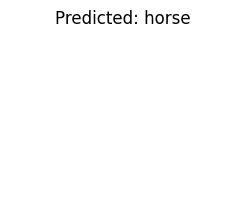

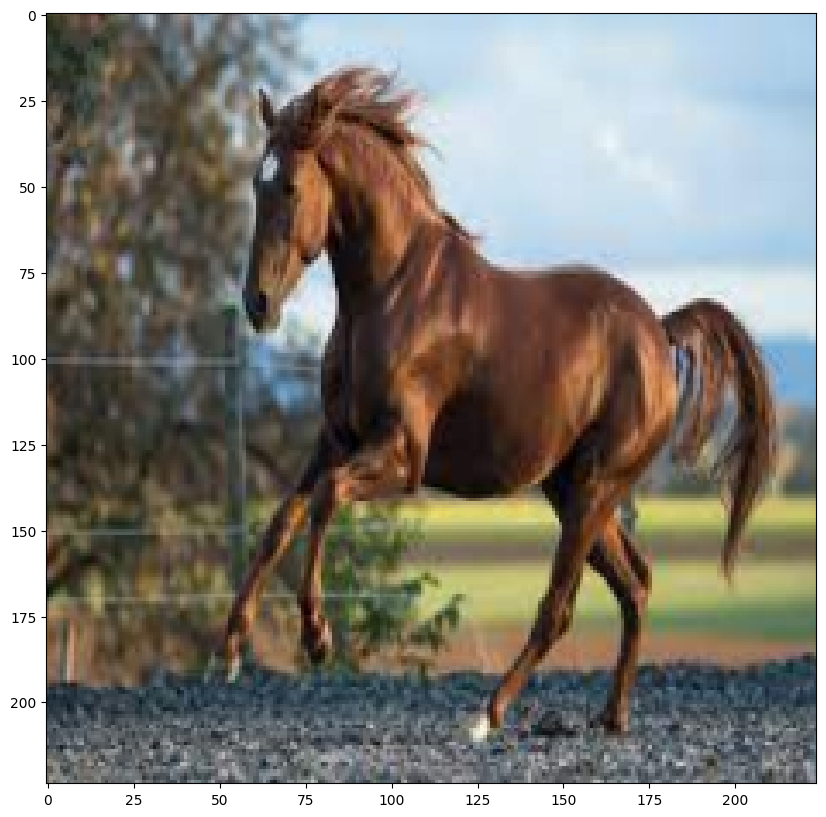

In [ ]:
# Visualize model predictions
visualize_model_predictions(pre_resnet18, img_path="/content/download.jpeg")

plt.ioff()
plt.show()

## Summary
When working with a small dataset, it is usual to use features learnt from a model trained on a bigger dataset in the same domain. This is accomplished by instantiating the pre-trained model and layering a fully connected classifier on top. The pre-trained model is "**frozen**," which means that only the classifier's weights change during training.

The convolutional base retrieved every feature associated with each picture, and we then trained a classifier to determine the image class using that set of extracted features.